In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import json
import random
import seaborn as sns
import re

import spacy

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

import unicodedata

from wordcloud import WordCloud, STOPWORDS

# ### Scikit-Learn ###
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as skmetrics

from pyannote.audio.pipelines import VoiceActivityDetection

import analysis_utils as aute

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


In [2]:
config_json = open("../LableniBotConfig/config.json")
config_dict = json.load(config_json)

hugging_face_key = config_dict["HUGGING_FACE"]

silence_detection_pipeline = VoiceActivityDetection(segmentation="pyannote/segmentation",
                                                    use_auth_token=hugging_face_key)

In [3]:
def get_audio_talk_duration(path_to_subj_conv):
    path_to_audios = path_to_subj_conv + "/Audios/"
    all_audios = os.listdir(path_to_audios)

    delta_talk_list = []
    for i_audio, audio in enumerate(all_audios):
        try:
            vad = silence_detection_pipeline(path_to_audios + audio)
        except:
            print("Bad audio", path_to_audios + audio)
            delta_talk_list.append(np.nan)

        seg_timeline = list(vad.get_timeline().segments_set_)
        
        if len(seg_timeline) > 0:
            start_time = np.min([seg.start for seg in seg_timeline])
            end_time = np.max([seg.end for seg in seg_timeline])

            delta_time_human_talk = end_time - start_time
            delta_talk_list.append(delta_time_human_talk)
        else:
            delta_talk_list.append(np.nan)
    
    return delta_talk_list

In [16]:
path_to_convs = "D:/GuardarDatosLableniBOT"

all_df_list = []
for subj in os.listdir(path_to_convs)[:]:
    if "User" in subj:
        print("Subject", subj, end="\r")
        path_to_conv_2 = path_to_convs + "/" + subj + "/" + subj + "_Conversations/"
        for file in os.listdir(path_to_conv_2):
            if "User" in file:
                path_to_subj_conv = path_to_conv_2 + file
                # try:
                csv_name = [file for file in os.listdir(path_to_subj_conv) if ".csv" in file][0]
                df_x = pd.read_csv(path_to_subj_conv + "/" + csv_name, sep=";")
                if df_x.shape[0] > 2:

                    df_x["DeltaHumanTalk"] = np.nan
                    delta_talk_list = get_audio_talk_duration(path_to_subj_conv)
                    d_talk_nona_list = [t for t in delta_talk_list if not np.isnan(t)]
                    source_person = df_x["Source"] == "Person"
                    if np.sum(source_person) < len(d_talk_nona_list):
                        df_x.loc[source_person, "DeltaHumanTalk"] = d_talk_nona_list[:np.sum(source_person)]
                    elif np.sum(source_person) == len(d_talk_nona_list):
                        df_x.loc[source_person, "DeltaHumanTalk"] = d_talk_nona_list
                    else:
                        for _ in range(np.sum(source_person) - len(d_talk_nona_list)):
                            d_talk_nona_list.append(np.nan)
                        df_x.loc[source_person, "DeltaHumanTalk"] = d_talk_nona_list

                    all_df_list.append(df_x)
                # except:
                    # print("Bad subject", path_to_subj_conv + "/" + csv_name)

Bad audio D:/GuardarDatosLableniBOT/User_11_CB/User_11_CB_Conversations/User_11_CB_20221123_100034/Audios/Subject_User_11_CB_T=5.wav
Bad audio D:/GuardarDatosLableniBOT/User_12_CB/User_12_CB_Conversations/User_12_CB_20221123_122103/Audios/Subject_User_12_CB_T=9.wav
Bad audio D:/GuardarDatosLableniBOT/User_12_CB/User_12_CB_Conversations/User_12_CB_20221123_122736/Audios/Subject_User_12_CB_T=8.wav
Bad audio D:/GuardarDatosLableniBOT/User_15_CB/User_15_CB_Conversations/User_15_CB_20221124_120946/Audios/Subject_User_15_CB_T=9.wav
Bad audio D:/GuardarDatosLableniBOT/User_15_CB/User_15_CB_Conversations/User_15_CB_20221124_122515/Audios/Subject_User_15_CB_T=8.wav
Bad audio D:/GuardarDatosLableniBOT/User_17_CB/User_17_CB_Conversations/User_17_CB_20221125_104412/Audios/Subject_User_17_CB_T=6.wav
Bad audio D:/GuardarDatosLableniBOT/User_19_CB/User_19_CB_Conversations/User_19_CB_20221125_144045/Audios/Subject_User_19_CB_T=11.wav
Bad audio D:/GuardarDatosLableniBOT/User_20_CB/User_20_CB_Conversati

IndexError: list index out of range

In [18]:
result_process_data_list = []
for data in all_df_list:
    
    personality, gender, _ = data["ConfigName"].iloc[0].split("_")
    
    gender = "Female" if gender == "Woman" else gender
    gender = "Male" if gender == "Man" else gender
    
    human_time_talk = (data["PersonTalkEndUnix"] - data["PersonTalkStartUnix"]).dropna().values
    bot_time_talk = (data["BotTalkEndUnix"] - data["BotTalkStartUnix"]).dropna().values
    conv_time = (data["UnixTimeSave"].iloc[-1] - data["UnixTimestampLoopInit"].iloc[0])/60
    max_num_pair_sentence = np.max([
        label for label in data["ConversationSentenceId"].unique() if np.sum(data["ConversationSentenceId"] == label) == 2
    ])
    result_process_data_list.append({
        "SubjectId": data["SubjectId"].iloc[0],
        "ChatbotName": data["ChatbotName"].iloc[0],
        "Gender": gender,
        "Personality": personality,
        "UnixLoopStart": data["UnixTimestampLoopInit"].iloc[0],
        "MeanHumanTime_s": np.mean(human_time_talk),
        "StdHumanTime_s": np.std(human_time_talk),
        "MaxHumanTime_s": np.max(human_time_talk),
        "FromAudioMeanHumanTime_s": np.nanmean(data["DeltaHumanTalk"]),
        "FromAudioStdHumanTime_s": np.nanstd(data["DeltaHumanTalk"]),
        "FromAudioMaxHumanTime_s": np.nanmax(data["DeltaHumanTalk"]),
        "MeanBotTime_s": np.mean(bot_time_talk),
        "StdBotTime_s": np.std(bot_time_talk),
        "MaxBotTime_s": np.max(bot_time_talk),
        "ConvTime_min": conv_time,
        "NumberOfSentences": data.shape[0],
        "MaxNumQA": max_num_pair_sentence,
        "NumSentencePerson": np.sum(data["Source"] == "Person"),
        "NumSentenceBot": np.sum(data["Source"] == "Bot"),
    })
    
df_res_process = pd.DataFrame(result_process_data_list)

In [19]:
print(df_res_process.columns)
print("Shape", df_res_process.shape)
df_res_process.head(10)

Index(['SubjectId', 'ChatbotName', 'Gender', 'Personality', 'UnixLoopStart',
       'MeanHumanTime_s', 'StdHumanTime_s', 'MaxHumanTime_s',
       'FromAudioMeanHumanTime_s', 'FromAudioStdHumanTime_s',
       'FromAudioMaxHumanTime_s', 'MeanBotTime_s', 'StdBotTime_s',
       'MaxBotTime_s', 'ConvTime_min', 'NumberOfSentences', 'MaxNumQA'],
      dtype='object')
Shape (206, 17)


,SubjectId,ChatbotName,Gender,Personality,UnixLoopStart,MeanHumanTime_s,StdHumanTime_s,MaxHumanTime_s,FromAudioMeanHumanTime_s,FromAudioStdHumanTime_s,FromAudioMaxHumanTime_s,MeanBotTime_s,StdBotTime_s,MaxBotTime_s,ConvTime_min,NumberOfSentences,MaxNumQA
0,User_11_CB,Ana,Female,Neutral,1.669194e+09,7.487375,1.557242,9.394597,2.446875,0.729734,3.661875,4.908687,1.552132,7.341591,1.507762,11,4
1,User_11_CB,Alejandro,Male,Neutral,1.669194e+09,7.017915,1.364921,9.427634,3.405586,1.865663,7.171875,5.090596,1.010189,6.823508,4.313851,33,15
2,User_11_CB,Lucía,Female,Relax,1.669195e+09,6.244338,0.010837,6.255175,1.468125,0.641250,2.109375,5.983278,0.419997,6.486332,0.675252,5,1
3,User_11_CB,Carlos,Male,Angry,1.669195e+09,7.823977,1.575770,9.464282,4.159688,2.401103,8.420625,8.883119,3.366829,15.931445,4.342793,24,11
4,User_11_CB,María,Female,Happy,1.669196e+09,6.523247,0.907325,9.391859,2.646307,1.516103,6.480000,6.862201,2.464372,11.795177,3.358991,23,10
5,User_11_CB,Daniel,Male,Sad,1.669196e+09,9.405147,4.663871,18.943190,5.325469,4.437919,13.584375,7.447752,2.813411,14.109570,4.323107,24,11
6,User_12_CB,David,Male,Neutral,1.669201e+09,8.172129,4.425992,22.151716,1.808221,1.037859,4.083750,6.085023,1.893712,8.502159,4.144871,27,12
7,User_12_CB,Laura,Female,Neutral,1.669202e+09,7.170712,1.449513,9.396725,2.009812,1.292727,4.336875,7.202766,2.059395,10.485668,3.305628,21,9
8,User_12_CB,Pablo,Male,Relax,1.669202e+09,6.677848,1.100366,9.377840,1.975580,1.022306,3.864375,6.901148,3.434003,15.908851,4.235855,29,13
9,User_12_CB,Marta,Female,Angry,1.669202e+09,8.337839,2.592614,12.571239,3.193125,2.030894,6.598125,8.347744,5.054337,17.929290,3.485238,19,8


In [20]:
df_res_process["SubjectId"] = df_res_process["SubjectId"].replace("Alejandro", "User_10_CB")

In [37]:
print("Number of Subjects", df_res_process["SubjectId"].nunique())
print("Subjects", df_res_process["SubjectId"].unique())

Number of Subjects 35
Subjects ['User_11_CB' 'User_12_CB' 'User_13_CB' 'User_14_CB' 'User_15_CB'
 'User_16_CB' 'User_17_CB' 'User_18_CB' 'User_19_CB' 'User_20_CB'
 'User_21_CB' 'User_22_CB' 'User_23_CB' 'User_24_CB' 'User_25_CB'
 'User_26_CB' 'User_27_CB' 'User_28_CB' 'User_29_CB' 'User_30_CB'
 'User_31_CB' 'User_32_CB' 'User_33_CB' 'User_34_CB' 'User_35_CB'
 'User_36_CB' 'User_37_CB' 'User_38_CB' 'User_39_CB' 'User_40_CB'
 'User_41_CB' 'User_42_CB' 'User_43_CB' 'User_44_CB' 'User_45_CB']


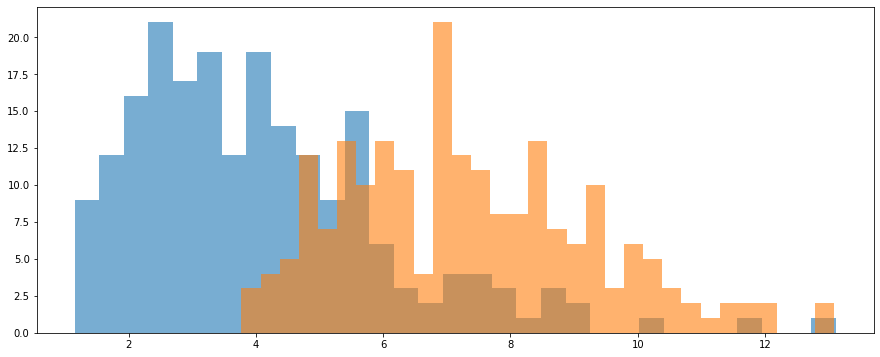

In [36]:
plt.figure(figsize=(15, 6))

plt.hist(df_res_process["FromAudioMeanHumanTime_s"], bins=31, alpha=0.6)
plt.hist(df_res_process["MeanBotTime_s"], bins=31, alpha=0.6)

plt.show()

In [47]:
df_res_process.to_csv("Results/DataConvProcessed.csv", sep=";", index=False)